# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn import preprocessing
%matplotlib inline

df = pd.read_csv('https://raw.githubusercontent.com/Columbia-Intro-Data-Science/APMAE4990-/master/data/hw2data.csv')

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

In [31]:
y = df['y']
X= df.drop(['y'], 1)

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.001

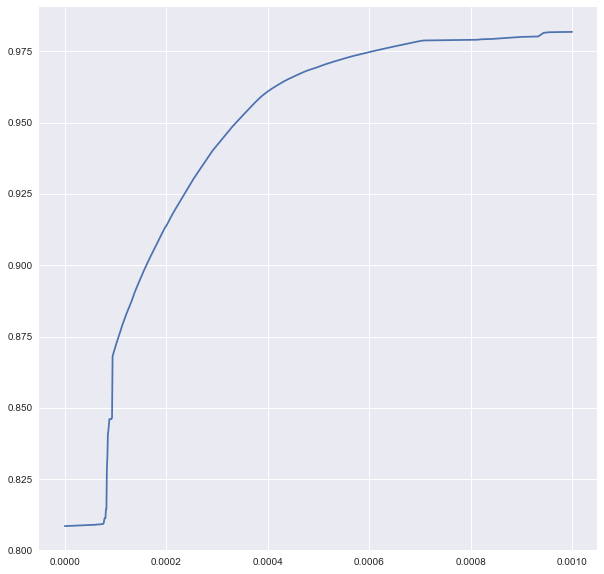

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

alphas = np.logspace(-8,-3,1000)
train_errors=[]
test_errors=[]
alpha_optim=0


for d in alphas:
    regr = Lasso(alpha=d)
    regr.fit(X_train, y_train)
    
    train_errors.append(regr.score(X_train,y_train))
    test_errors.append(regr.score(X_test,y_test))
    
    
plt.figure(figsize=(10,10))
plt.plot(alphas, test_errors)
    
i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
alpha_optim

Based on the above plot, we can find the regularization strength
which optimizes the $R^2$ is 0.001.

d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

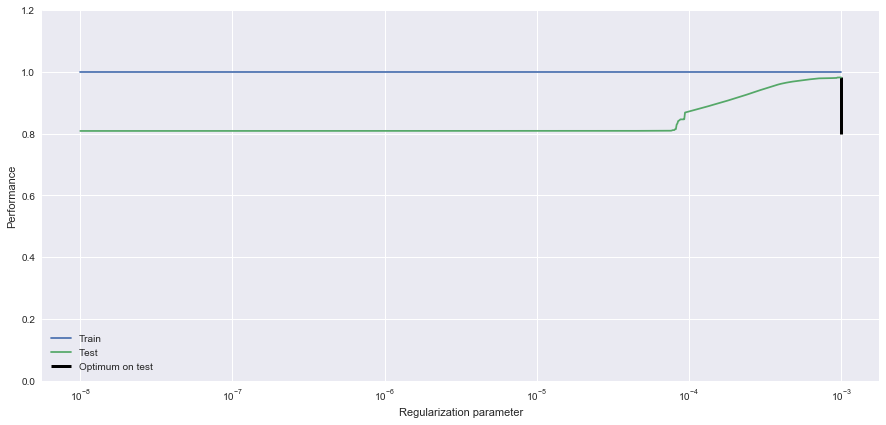

In [110]:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)


plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')


plt.show()


Based on the above plot, we can find the test performance is maximized at $\lambda$ = 0.001

e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

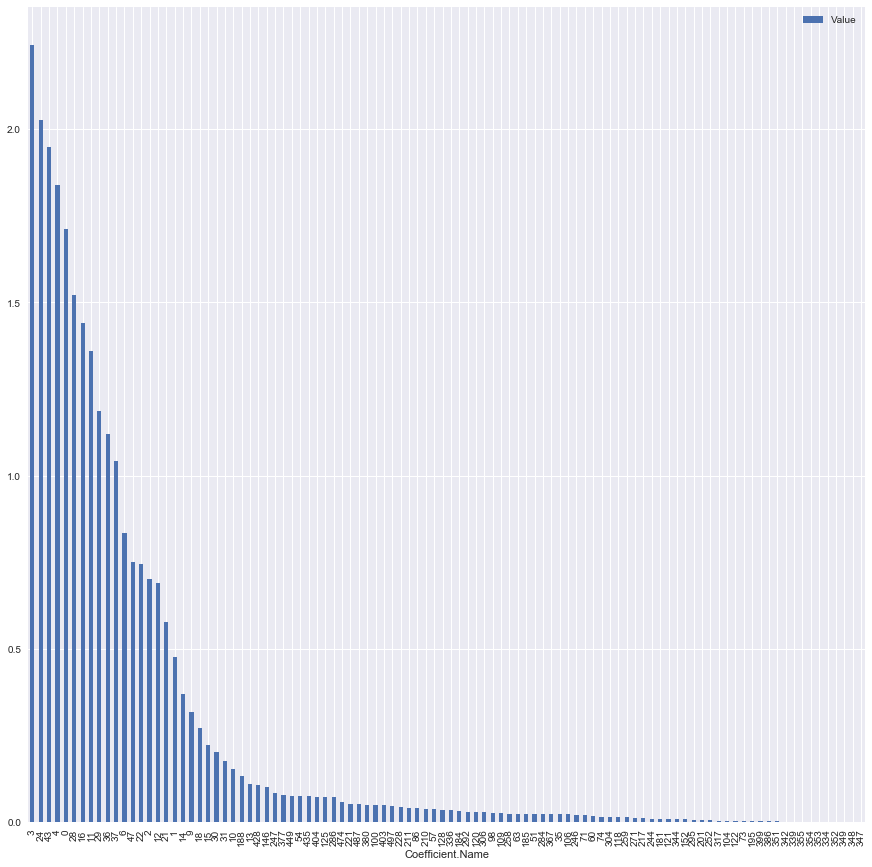

In [114]:
regr = Lasso(alpha=alpha_optim)
regr.fit(X_train, y_train)


coefd = {'Coefficient.Name': range(len(regr.coef_)), 'Value': regr.coef_}
coefdf = pd.DataFrame(data = coefd)

coefdf = coefdf.sort_values(['Value'], ascending=False)
coefdf[0:100].plot(x='Coefficient.Name',y='Value', kind='bar', figsize=(15,15))
plt.show()

For Lasso, it use $L_{1}$ normal for a constraint. So the shape of the constraint region is diamond. The optimal point is a point which is common point between the elliptical contour plot of the sum of squared error term and the constraint as well as gives a minimum value for the regression objective function. There is a high probability that optimum point falls in the corner point of diamond region, which means the coefficient of the corresponding estimator is 0. This is why there are so many zeros in the model.

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

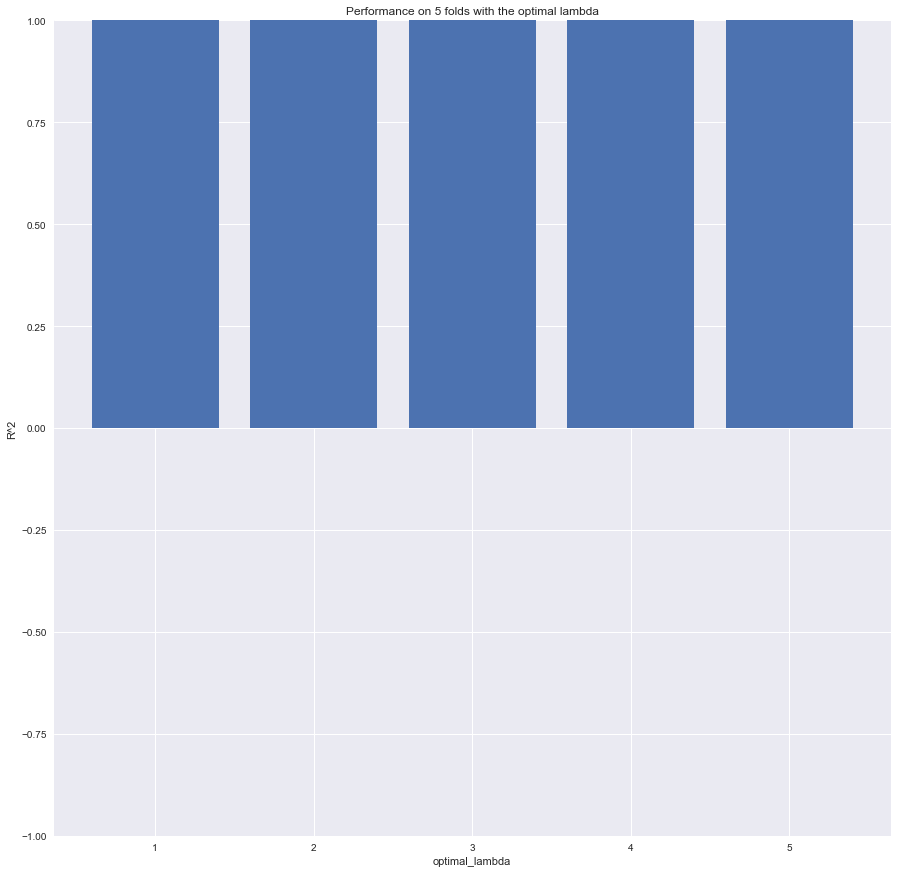

In [100]:
regr = Lasso(alpha=alpha_optim)
scores = cross_val_score(regr, X, y, cv=5)

plt.figure(figsize=(15,15))
plt.ylim([-1,1])
plt.xlabel('optimal_lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with the optimal lambda')
plt.bar(range(1,6),scores)

plt.show()

Based on the above plot, we can find the $R^2$ value for every random subset is very close to 1. Therefore, we can conclude that the model work well on all random subsets.

f) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [102]:
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_optim)

In [103]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

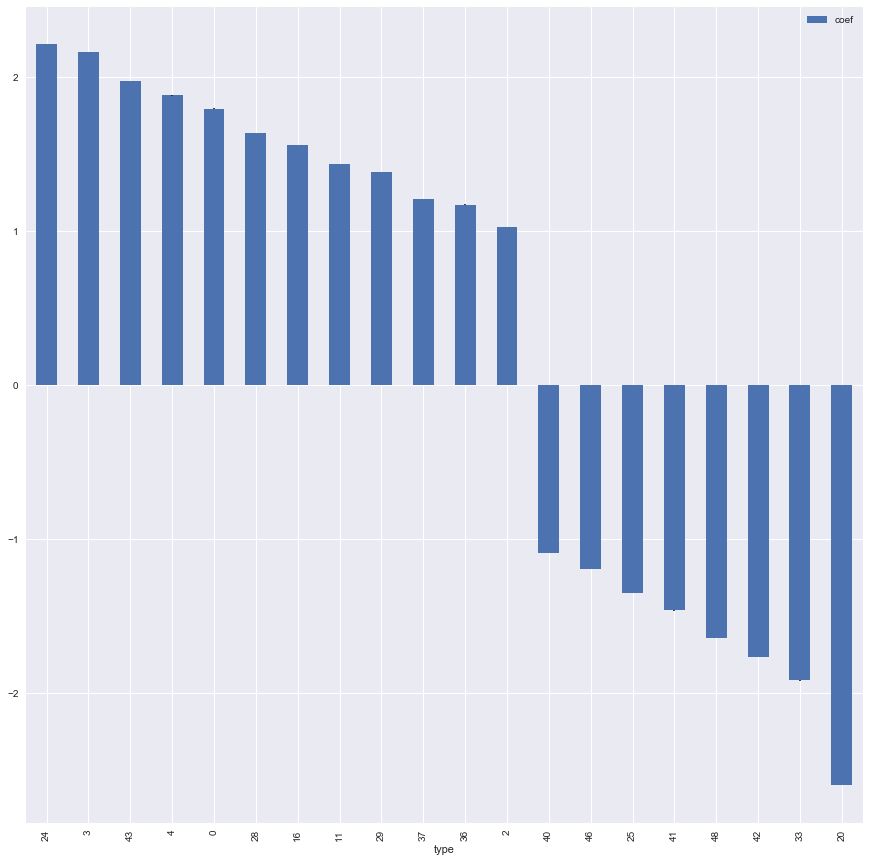

In [108]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'], ascending=False)
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))